In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from collections import OrderedDict

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

## T1 PvL

In [2]:
data_time1 = pd.read_csv('RF_time1.tsv',sep='\t', index_col = 0)
#data = data.T
data_time1

,Turicibacteraceae_denovo100756,Bacteroidales_denovo10173,Clostridiales_denovo102587,Ruminococcaceae_denovo102843,Clostridiales_denovo106718,Lactobacillaceae_denovo106827,RF39_denovo115899,Clostridiales_denovo120556,Clostridiales_denovo120932,Lachnospiraceae_denovo125573,...,Clostridiales_denovo60687,Clostridiales_denovo63815,Clostridiales_denovo68168,Alcaligenaceae_denovo71630,Lachnospiraceae_denovo79490,Ruminococcaceae_denovo80874,Clostridiales_denovo92104,RF39_denovo96765,time_point,Treatment
OTU_ID,,,,,,,,,,,,,,,,,,,,,
340.T1,109,1132,37,13,0,1,1,0,2,2,...,0,17,0,1,31,10,0,7,1,Placebo
341.T1,20,450,9,0,0,0,0,1,0,7,...,0,1,0,1,90,6,0,4,1,Placebo
342.T1,7,1667,9,5,1,1,1,0,0,0,...,1,3,0,1,3,2,1,0,1,Placebo
344.T1,6,253,3,2,1,0,0,0,0,0,...,67,2,0,1,59,6,0,0,1,Placebo
345.T1,3,358,0,1,1,0,0,0,0,0,...,226,0,0,2,3,7,0,2,1,Placebo
347.T1,6,1360,1,1,0,18,0,0,6,0,...,3,23,0,1,1,14,1,2,1,Placebo
348.T1,3,3484,5,2,1,10,2,0,0,0,...,1,3,1,0,3,7,0,1,1,Placebo
349.T1,2,1181,1,0,1,12,1,0,0,1,...,0,20,0,0,19,1,2,0,1,Placebo
351.T1,7,113,0,0,0,0,3,2,3,12,...,5,106,0,5,1,3,5,5,1,Letrozole


In [3]:
data_time1.iloc[:,55]

OTU_ID
340.T1      Placebo
341.T1      Placebo
342.T1      Placebo
344.T1      Placebo
345.T1      Placebo
347.T1      Placebo
348.T1      Placebo
349.T1      Placebo
351.T1    Letrozole
352.T1    Letrozole
353.T1    Letrozole
355.T1    Letrozole
356.T1    Letrozole
359.T1    Letrozole
360.T1    Letrozole
361.T1    Letrozole
Name: Treatment, dtype: object

In [4]:
# Split the Groups from the dataset where y is category and x is data with species
y = data_time1.iloc[:,55]
x = data_time1.iloc[:,0:54]

In [5]:
# Split the data into training and test data for the categories(y) and dataset(x)
# Here we are spliting it 65% training and 35% test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.35, random_state=42)

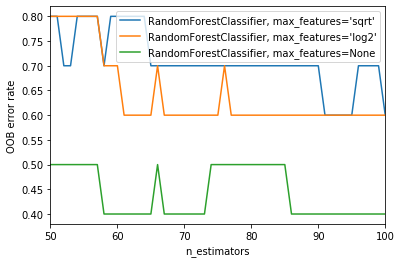

In [6]:
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt", 
                               random_state=42)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True, 
                               random_state=42)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True, 
                               random_state=42))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 50
max_estimators = 100

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [7]:
clf = RandomForestClassifier(n_estimators=70, max_features=None, random_state=42)
all_accuracies = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5)
print('Mean Validation Scores: ' ,end='')
print(np.mean(all_accuracies))

Mean Validation Scores: 0.5


In [8]:
clf_final = RandomForestClassifier(n_estimators=70, bootstrap=True,max_features=None,oob_score= True,
                                   random_state= 42)
clf_final.fit(X_train,y_train)
y_pred = clf_final.predict(X_test)
print("Test Set Accuracy:",metrics.accuracy_score(y_test, y_pred))

Test Set Accuracy: 0.8333333333333334


In [9]:
rf_probs = clf_final.predict_proba(X_test)[:, 1]
roc_value = roc_auc_score(y_test, rf_probs)
roc_value

0.888888888888889

In [10]:
print(clf_final.oob_score_)

0.6


In [12]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(data_time1.columns, clf_final.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
imp=importances.sort_values(by='Gini-importance',ascending=False)
imp.head(20)

,Gini-importance
Bacteroidales_denovo10173,0.195238
Clostridiales_denovo146153,0.175850
Lachnospiraceae_denovo79490,0.095578
S24-7_denovo45929,0.071429
Alcaligenaceae_denovo71630,0.071429
Bacteroidales_denovo52943,0.042857
Clostridiales_denovo63815,0.038095
Clostridiales_denovo58760,0.037755
Clostridiales_denovo13487,0.033333
Bacteroidales_denovo2846,0.028571


In [13]:
imp.head(10).to_csv("RF_plot_time1.csv")

## T2 PvL

In [14]:
data_time2 = pd.read_csv('RF_time2.tsv',sep='\t', index_col = 0)
#data = data.T
data_time2

,Turicibacteraceae_denovo100756,Bacteroidales_denovo10173,Clostridiales_denovo102587,Ruminococcaceae_denovo102843,Clostridiales_denovo106718,Lactobacillaceae_denovo106827,RF39_denovo115899,Clostridiales_denovo120556,Clostridiales_denovo120932,Lachnospiraceae_denovo125573,...,Clostridiales_denovo60687,Clostridiales_denovo63815,Clostridiales_denovo68168,Alcaligenaceae_denovo71630,Lachnospiraceae_denovo79490,Ruminococcaceae_denovo80874,Clostridiales_denovo92104,RF39_denovo96765,time_point,Treatment
OTU_ID,,,,,,,,,,,,,,,,,,,,,
340.T2,136,661,0,15,0,3,1,0,0,0,...,1,32,0,5,2,1,2,2,2,Placebo
341.T2,81,471,6,6,0,1,1,3,0,0,...,1,0,0,1,19,4,0,0,2,Placebo
342.T2,14,1057,203,4,1,0,0,1,1,0,...,13,4,2,3,4,7,1,0,2,Placebo
344.T2,3,158,4,0,0,0,0,0,0,0,...,56,0,0,1,41,4,0,2,2,Placebo
345.T2,6,1580,1,2,0,6,0,0,0,0,...,21,7,1,2,1,1,0,0,2,Placebo
347.T2,5,1773,0,2,0,9,0,0,6,0,...,3,7,0,3,0,2,0,0,2,Placebo
348.T2,2,801,1,1,1,0,1,2,0,0,...,4,0,0,4,2,2,0,1,2,Placebo
349.T2,4,907,2,3,0,0,0,2,4,0,...,1,0,0,0,36,3,0,0,2,Placebo
351.T2,33,121,1,1,4,0,3,2,0,4,...,7,70,1,2,0,2,1,9,2,Letrozole


In [15]:
data_time2.iloc[:,55]

OTU_ID
340.T2      Placebo
341.T2      Placebo
342.T2      Placebo
344.T2      Placebo
345.T2      Placebo
347.T2      Placebo
348.T2      Placebo
349.T2      Placebo
351.T2    Letrozole
352.T2    Letrozole
353.T2    Letrozole
355.T2    Letrozole
356.T2    Letrozole
359.T2    Letrozole
360.T2    Letrozole
361.T2    Letrozole
Name: Treatment, dtype: object

In [16]:
# Split the Groups from the dataset where y is category and x is data with species
y = data_time2.iloc[:,55]
x = data_time2.iloc[:,0:54]

In [17]:
# Split the data into training and test data for the categories(y) and dataset(x)
# Here we are spliting it 65% training and 35% test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.35, random_state=42)

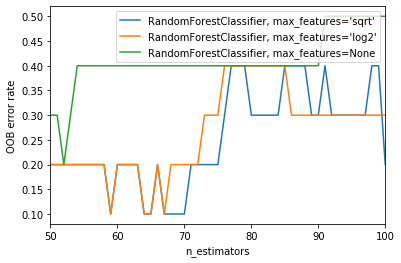

In [18]:
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt", 
                               random_state=42)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True, 
                               random_state=42)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True, 
                               random_state=42))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 50
max_estimators = 100

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [19]:
clf = RandomForestClassifier(n_estimators=70, max_features='sqrt', random_state=42)
all_accuracies = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5)
print('Mean Validation Scores: ' ,end='')
print(np.mean(all_accuracies))

Mean Validation Scores: 0.9


In [20]:
clf_final = RandomForestClassifier(n_estimators=70, bootstrap=True,max_features='sqrt',oob_score= True,
                                   random_state= 42)
clf_final.fit(X_train,y_train)
y_pred = clf_final.predict(X_test)
print("Test Set Accuracy:",metrics.accuracy_score(y_test, y_pred))

Test Set Accuracy: 0.8333333333333334


In [21]:
rf_probs = clf_final.predict_proba(X_test)[:, 1]
roc_value = roc_auc_score(y_test, rf_probs)
roc_value

1.0

In [22]:
print(clf_final.oob_score_)

0.9


In [23]:
feature_importance = pd.Series(clf_final.feature_importances_).sort_values(ascending=False)
feature_importance.head(20)

36    0.150794
9     0.062755
14    0.061905
39    0.057143
28    0.047619
49    0.046667
0     0.042857
42    0.037755
20    0.037755
1     0.036735
47    0.035261
50    0.035034
52    0.028571
31    0.027381
46    0.024150
21    0.023469
25    0.023469
29    0.022307
53    0.019660
51    0.019388
dtype: float64

In [24]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(data_time1.columns, clf_final.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
imp=importances.sort_values(by='Gini-importance',ascending=False)
imp.head(20)

,Gini-importance
S24-7_denovo44661,0.150794
Lachnospiraceae_denovo125573,0.062755
Clostridiales_denovo135866,0.061905
Lachnospiraceae_denovo46110,0.057143
[Paraprevotellaceae]_denovo21690,0.047619
Alcaligenaceae_denovo71630,0.046667
Turicibacteraceae_denovo100756,0.042857
Bacteroidales_denovo52943,0.037755
Clostridiales_denovo147899,0.037755
Bacteroidales_denovo10173,0.036735


In [25]:
imp.head(10).to_csv("RF_plot_time2.csv")

## T3 PvL

In [26]:
data_time3 = pd.read_csv('RF_time3.tsv',sep='\t', index_col = 0)
#data = data.T
data_time3

,Turicibacteraceae_denovo100756,Bacteroidales_denovo10173,Clostridiales_denovo102587,Ruminococcaceae_denovo102843,Clostridiales_denovo106718,Lactobacillaceae_denovo106827,RF39_denovo115899,Clostridiales_denovo120556,Clostridiales_denovo120932,Lachnospiraceae_denovo125573,...,Clostridiales_denovo60687,Clostridiales_denovo63815,Clostridiales_denovo68168,Alcaligenaceae_denovo71630,Lachnospiraceae_denovo79490,Ruminococcaceae_denovo80874,Clostridiales_denovo92104,RF39_denovo96765,time_point,Treatment
OTU_ID,,,,,,,,,,,,,,,,,,,,,
340.T3,166,191,1,13,0,3,2,0,1,0,...,1,4,0,1,15,0,0,0,3,Placebo
341.T3,62,663,6,6,0,0,1,1,4,1,...,1,5,0,2,78,11,0,3,3,Placebo
342.T3,2,1202,24,16,0,1,1,0,2,0,...,3,11,0,0,3,1,1,0,3,Placebo
344.T3,3,165,2,9,0,0,0,0,0,0,...,89,1,0,0,37,7,0,1,3,Placebo
345.T3,2,144,3,1,0,0,1,2,0,1,...,58,5,0,0,13,7,0,0,3,Placebo
347.T3,5,1604,0,3,1,0,0,0,6,0,...,1,0,0,0,1,12,0,1,3,Placebo
348.T3,1,387,1,3,0,0,0,2,0,0,...,14,2,0,1,3,3,1,5,3,Placebo
349.T3,1,1137,1,44,0,0,1,0,2,0,...,1,4,0,1,4,2,3,1,3,Placebo
351.T3,86,105,0,2,86,2,5,3,2,0,...,14,26,3,0,28,0,1,3,3,Letrozole


In [27]:
data_time3.iloc[:,57]

IndexError: single positional indexer is out-of-bounds

In [28]:
# Split the Groups from the dataset where y is category and x is data with species
y = data_time3.iloc[:,55]
x = data_time3.iloc[:,0:54]

In [29]:
# Split the data into training and test data for the categories(y) and dataset(x)
# Here we are spliting it 65% training and 35% test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.35, random_state=42)

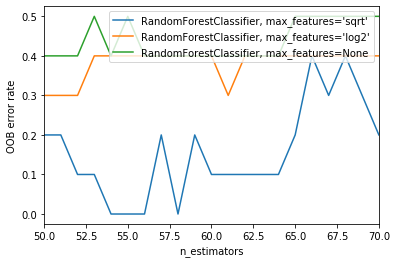

In [30]:
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt", 
                               random_state=42)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True, 
                               random_state=42)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True, 
                               random_state=42))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 50
max_estimators = 70

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [31]:
clf = RandomForestClassifier(n_estimators=55, max_features='sqrt', random_state=42)
all_accuracies = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5)
print('Mean Validation Scores: ' ,end='')
print(np.mean(all_accuracies))

Mean Validation Scores: 0.9


In [32]:
clf_final = RandomForestClassifier(n_estimators=55, bootstrap=True,max_features='sqrt',oob_score= True,
                                   random_state= 42)
clf_final.fit(X_train,y_train)
y_pred = clf_final.predict(X_test)
print("Test Set Accuracy:",metrics.accuracy_score(y_test, y_pred))

Test Set Accuracy: 0.6666666666666666


In [33]:
rf_probs = clf_final.predict_proba(X_test)[:, 1]
roc_value = roc_auc_score(y_test, rf_probs)
roc_value

0.888888888888889

In [34]:
print(clf_final.oob_score_)

1.0


In [35]:
feature_importance = pd.Series(clf_final.feature_importances_).sort_values(ascending=False)
feature_importance.head(20)

36    0.070022
51    0.066667
30    0.060750
39    0.060606
11    0.060426
29    0.052381
28    0.050216
48    0.046753
16    0.040909
6     0.036364
17    0.030303
20    0.029870
13    0.025325
42    0.023629
1     0.023485
10    0.022060
46    0.021861
9     0.018615
47    0.018615
32    0.018182
dtype: float64

In [36]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(data_time1.columns, clf_final.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
imp=importances.sort_values(by='Gini-importance',ascending=False)
imp.head(20)

,Gini-importance
S24-7_denovo44661,0.070022
Ruminococcaceae_denovo80874,0.066667
Clostridiales_denovo24794,0.060750
Lachnospiraceae_denovo46110,0.060606
Bacteroidales_denovo128655,0.060426
Lachnospiraceae_denovo2281,0.052381
[Paraprevotellaceae]_denovo21690,0.050216
Clostridiales_denovo68168,0.046753
Lactobacillaceae_denovo139763,0.040909
RF39_denovo115899,0.036364


In [37]:
imp.head(10).to_csv("RF_plot_time3.csv")

## T4 PvL

In [38]:
data_time4 = pd.read_csv('RF_time4.tsv',sep='\t', index_col = 0)
#data = data.T
data_time4

,Turicibacteraceae_denovo100756,Bacteroidales_denovo10173,Clostridiales_denovo102587,Ruminococcaceae_denovo102843,Clostridiales_denovo106718,Lactobacillaceae_denovo106827,RF39_denovo115899,Clostridiales_denovo120556,Clostridiales_denovo120932,Lachnospiraceae_denovo125573,...,Clostridiales_denovo60687,Clostridiales_denovo63815,Clostridiales_denovo68168,Alcaligenaceae_denovo71630,Lachnospiraceae_denovo79490,Ruminococcaceae_denovo80874,Clostridiales_denovo92104,RF39_denovo96765,time_point,Treatment
OTU_ID,,,,,,,,,,,,,,,,,,,,,
340.T4,59,176,4,45,0,0,0,0,1,0,...,4,67,0,4,21,4,0,0,4,Placebo
341.T4,39,916,5,11,0,0,6,0,4,0,...,1,4,0,0,21,5,1,3,4,Placebo
342.T4,17,1119,72,14,0,0,0,0,1,0,...,1,3,0,5,6,2,0,0,4,Placebo
344.T4,5,230,4,0,0,0,2,0,1,1,...,152,4,0,2,38,7,0,0,4,Placebo
345.T4,1,688,3,5,0,0,1,0,0,0,...,150,1,0,1,12,6,0,0,4,Placebo
347.T4,3,901,1,0,0,0,0,0,1,0,...,2,14,1,1,0,3,0,3,4,Placebo
348.T4,5,650,2,4,1,0,4,5,4,0,...,19,6,1,4,13,13,0,11,4,Placebo
349.T4,5,886,1,0,1,0,0,3,5,0,...,3,3,0,5,17,10,0,0,4,Placebo
351.T4,12,32,0,0,53,0,2,2,0,2,...,1,8,10,0,28,1,1,4,4,Letrozole


In [39]:
data_time4.iloc[:,0:57]

,Turicibacteraceae_denovo100756,Bacteroidales_denovo10173,Clostridiales_denovo102587,Ruminococcaceae_denovo102843,Clostridiales_denovo106718,Lactobacillaceae_denovo106827,RF39_denovo115899,Clostridiales_denovo120556,Clostridiales_denovo120932,Lachnospiraceae_denovo125573,...,Clostridiales_denovo60687,Clostridiales_denovo63815,Clostridiales_denovo68168,Alcaligenaceae_denovo71630,Lachnospiraceae_denovo79490,Ruminococcaceae_denovo80874,Clostridiales_denovo92104,RF39_denovo96765,time_point,Treatment
OTU_ID,,,,,,,,,,,,,,,,,,,,,
340.T4,59,176,4,45,0,0,0,0,1,0,...,4,67,0,4,21,4,0,0,4,Placebo
341.T4,39,916,5,11,0,0,6,0,4,0,...,1,4,0,0,21,5,1,3,4,Placebo
342.T4,17,1119,72,14,0,0,0,0,1,0,...,1,3,0,5,6,2,0,0,4,Placebo
344.T4,5,230,4,0,0,0,2,0,1,1,...,152,4,0,2,38,7,0,0,4,Placebo
345.T4,1,688,3,5,0,0,1,0,0,0,...,150,1,0,1,12,6,0,0,4,Placebo
347.T4,3,901,1,0,0,0,0,0,1,0,...,2,14,1,1,0,3,0,3,4,Placebo
348.T4,5,650,2,4,1,0,4,5,4,0,...,19,6,1,4,13,13,0,11,4,Placebo
349.T4,5,886,1,0,1,0,0,3,5,0,...,3,3,0,5,17,10,0,0,4,Placebo
351.T4,12,32,0,0,53,0,2,2,0,2,...,1,8,10,0,28,1,1,4,4,Letrozole


In [40]:
# Split the Groups from the dataset where y is category and x is data with species
y = data_time4.iloc[:,55]
x = data_time4.iloc[:,0:54]

In [41]:
# Split the data into training and test data for the categories(y) and dataset(x)
# Here we are spliting it 65% training and 35% test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.35, random_state=42)

In [ ]:
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt", 
                               random_state=42)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True, 
                               random_state=42)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True, 
                               random_state=42))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 300
max_estimators = 400

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [ ]:
clf = RandomForestClassifier(n_estimators=400, max_features='sqrt', random_state=42)
all_accuracies = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5)
print('Mean Validation Scores: ' ,end='')
print(np.mean(all_accuracies))

In [48]:
clf_final = RandomForestClassifier(n_estimators=400, bootstrap=True,max_features='sqrt',oob_score= True,
                                   random_state= 42)
clf_final.fit(X_train,y_train)
y_pred = clf_final.predict(X_test)
print("Test Set Accuracy:",metrics.accuracy_score(y_test, y_pred))

Test Set Accuracy: 1.0


In [49]:
rf_probs = clf_final.predict_proba(X_test)[:, 1]
roc_value = roc_auc_score(y_test, rf_probs)
roc_value

1.0

In [50]:
print(clf_final.oob_score_)

1.0


In [51]:
feature_importance = pd.Series(clf_final.feature_importances_).sort_values(ascending=False)
feature_importance.head(20)

21    0.102222
11    0.087976
33    0.061508
36    0.054792
49    0.048125
20    0.045506
8     0.044435
9     0.040060
39    0.036607
42    0.036553
1     0.032188
40    0.029167
14    0.027500
22    0.023333
41    0.023333
50    0.020615
51    0.019504
0     0.017143
30    0.016610
4     0.015982
dtype: float64

In [52]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(data_time1.columns, clf_final.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
imp=importances.sort_values(by='Gini-importance',ascending=False)
imp.head(20)

,Gini-importance
Clostridiales_denovo151126,0.102222
Bacteroidales_denovo128655,0.087976
Ruminococcaceae_denovo40343,0.061508
S24-7_denovo44661,0.054792
Alcaligenaceae_denovo71630,0.048125
Clostridiales_denovo147899,0.045506
Clostridiales_denovo120932,0.044435
Lachnospiraceae_denovo125573,0.040060
Lachnospiraceae_denovo46110,0.036607
Bacteroidales_denovo52943,0.036553


In [53]:
imp.head(20).to_csv("RF_plot_time4.csv")

## T5 PvL

In [54]:
data_time5 = pd.read_csv('RF_time5.tsv',sep='\t', index_col = 0)
#data = data.T
data_time5

,Turicibacteraceae_denovo100756,Bacteroidales_denovo10173,Clostridiales_denovo102587,Ruminococcaceae_denovo102843,Clostridiales_denovo106718,Lactobacillaceae_denovo106827,RF39_denovo115899,Clostridiales_denovo120556,Clostridiales_denovo120932,Lachnospiraceae_denovo125573,...,Clostridiales_denovo60687,Clostridiales_denovo63815,Clostridiales_denovo68168,Alcaligenaceae_denovo71630,Lachnospiraceae_denovo79490,Ruminococcaceae_denovo80874,Clostridiales_denovo92104,RF39_denovo96765,time_point,Treatment
OTU_ID,,,,,,,,,,,,,,,,,,,,,
340.T5,6,255,6,33,2,0,4,1,0,0,...,16,6,4,1,29,1,0,0,5,Placebo
341.T5,2,899,6,2,1,0,0,0,1,0,...,17,2,3,0,24,13,0,0,5,Placebo
342.T5,3,1477,29,37,0,0,1,6,0,0,...,21,28,0,0,11,1,0,0,5,Placebo
344.T5,5,508,3,1,2,0,0,0,0,0,...,27,1,3,0,9,1,0,3,5,Placebo
345.T5,3,693,3,2,0,0,1,1,0,0,...,88,2,0,0,24,7,0,0,5,Placebo
347.T5,0,837,0,0,0,0,0,0,1,0,...,1,20,0,2,2,1,2,2,5,Placebo
348.T5,2,392,4,0,0,0,0,11,3,0,...,17,1,1,0,25,4,0,1,5,Placebo
349.T5,3,493,3,23,0,0,0,1,0,0,...,2,5,3,0,9,0,3,0,5,Placebo
351.T5,8,98,0,1,60,0,2,0,0,3,...,0,1,10,0,6,1,0,0,5,Letrozole


In [69]:
data_time5.iloc[:,0:57]

,Ruminococcaceae_denovo10000,Clostridiales_denovo100731,Clostridiales_denovo137602,Ruminococcaceae_denovo137967,RF39_denovo147868,Clostridiales_denovo152861,Clostridiales_denovo153245,Clostridiales_denovo167428,Clostridiales_denovo167887,Lachnospiraceae_denovo174953,...,Lactobacillaceae_denovo489518,RF39_denovo494541,RF39_denovo556210,Bifidobacteriaceae_denovo55677,Clostridiales_denovo65513,Enterobacteriaceae_denovo72427,Deferribacteraceae_denovo76908,Lachnospiraceae_denovo78453,Lactobacillaceae_denovo78833,Ruminococcaceae_denovo82126
OTU_ID,,,,,,,,,,,,,,,,,,,,,
C01P5A,1,7,1,0,4,1,1,0,2,0,...,0,17,8,27,1,0,105,1,1185,0
C02P5A,0,2,6,0,1,48,1,1,1,0,...,0,0,34,36,0,0,60,4,786,0
C03P5B,7,3,17,112,0,1,0,1,250,0,...,0,50,5,75,0,0,881,0,339,23
C04P5B,3,71,3,12,0,0,0,13,7,0,...,2,1,5,79,1,1,58,0,1480,3
C05P5C,1,49,0,0,0,4,1,10,81,1,...,0,44,3,1102,0,0,214,0,44,3
C06P5C,0,0,0,0,0,0,0,0,0,1,...,0,0,1,100,0,0,210,1,30,1
C07P5D,1,8,1,12,0,30,14,1,0,7,...,0,67,21,13,0,0,1794,1,56,2
C08P5D,0,61,0,5,80,7,3,0,2,3,...,0,268,2,11,0,0,4288,9,47,9
C09P5E,1,124,1,58,0,3,0,0,1,1,...,0,121,27,2,1,0,6281,1,278,14


In [56]:
# Split the Groups from the dataset where y is category and x is data with species
y = data_time5.iloc[:,55]
x = data_time5.iloc[:,0:54]

In [57]:
# Split the data into training and test data for the categories(y) and dataset(x)
# Here we are spliting it 65% training and 35% test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.35, random_state=42)

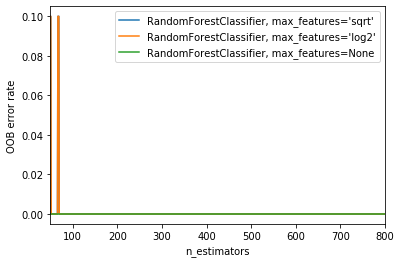

In [58]:
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt", 
                               random_state=42)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True, 
                               random_state=42)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True, 
                               random_state=42))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 50
max_estimators = 800

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [59]:
clf = RandomForestClassifier(n_estimators=100, max_features=None, random_state=42)
all_accuracies = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5)
print('Mean Validation Scores: ' ,end='')
print(np.mean(all_accuracies))

Mean Validation Scores: 1.0


In [60]:
clf_final = RandomForestClassifier(n_estimators=100, bootstrap=True,max_features=None,oob_score= True,
                                   random_state= 42)
clf_final.fit(X_train,y_train)
y_pred = clf_final.predict(X_test)
print("Test Set Accuracy:",metrics.accuracy_score(y_test, y_pred))

Test Set Accuracy: 0.6666666666666666


In [61]:
rf_probs = clf_final.predict_proba(X_test)[:, 1]
roc_value = roc_auc_score(y_test, rf_probs)
roc_value

0.5555555555555556

In [62]:
print(clf_final.oob_score_)

1.0


In [63]:
feature_importance = pd.Series(clf_final.feature_importances_).sort_values(ascending=False)
feature_importance.head(20)

1     0.13
41    0.12
50    0.11
2     0.09
31    0.08
11    0.07
39    0.07
40    0.06
35    0.04
0     0.03
14    0.03
25    0.03
20    0.02
36    0.02
51    0.02
19    0.01
27    0.01
16    0.01
33    0.01
49    0.01
dtype: float64

In [64]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(data_time1.columns, clf_final.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
imp=importances.sort_values(by='Gini-importance',ascending=False)
imp.head(20)

,Gini-importance
Bacteroidales_denovo10173,0.13
Lactobacillaceae_denovo4701,0.12
Lachnospiraceae_denovo79490,0.11
Clostridiales_denovo102587,0.09
Bacteroidales_denovo2846,0.08
Lachnospiraceae_denovo46110,0.07
Bacteroidales_denovo128655,0.07
Bacteroidales_denovo46779,0.06
Clostridiales_denovo4187,0.04
Clostridiales_denovo135866,0.03


In [65]:
imp.head(20).to_csv("RF_plot_time5.csv")